In [1]:
import torch
from d2l import torch as d2l
import pandas as pd
import os
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from sklearn.metrics import mean_absolute_error, r2_score

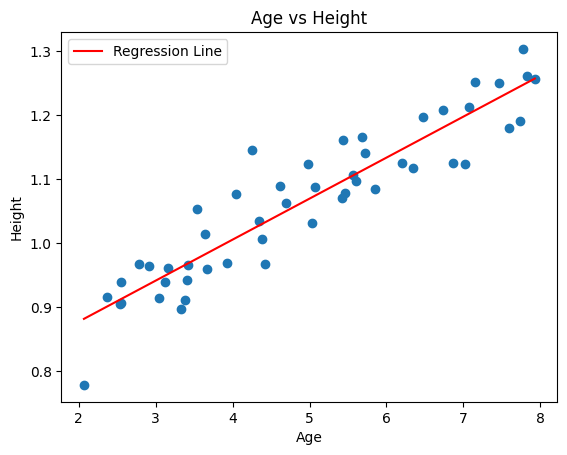

In [122]:
seed_value = 5
torch.manual_seed(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

def plot_csv_data(model=None):
    # Read the CSV file
    df = pd.read_csv('AgeHeight.csv')

    # Extract the age and height columns
    age = df['Age']
    height = df['HeightMeters']

    # insert original data as scatter plot
    plt.scatter(age, height)

    # get linear regression function
    coefficients = np.polyfit(age, height, 1)
    line_function = np.poly1d(coefficients)

    # plot regression line
    line_x = np.linspace(min(age), max(age), 100)
    line_y = line_function(line_x)
    plt.plot(line_x, line_y, label='Regression Line', color='red')
    
    if model:
        w, b = model.get_w_b()
        w = w.item()
        b = b.item()

        # Calculate the corresponding y values
        preds = w * line_x + b

        # Plot the line
        plt.plot(line_x, preds, label=f'Generated Line\ny = {w}x + {b}', color='green')

    plt.xlabel('Age')
    plt.ylabel('Height')
    plt.title('Age vs Height')
    plt.legend()

    # display graph
    plt.show()
    
plot_csv_data()

In [123]:
class AgeHeightDataModule(d2l.HyperParameters):
    def __init__(self, csv_path='AgeHeight.csv'):
        super().__init__()
        self.save_hyperparameters()
        self.csv_path = csv_path
        
        # read CSV
        df = pd.read_csv(self.csv_path)
        # shuffle
        df = df.sample(frac=1).reset_index(drop=True)

        self.batch_size = 5
        
        # train 80%, val 10%, test 10%
        self.train_df, temp_df = train_test_split(df, test_size=0.2, random_state=seed_value)
        self.val_df, self.test_df = train_test_split(temp_df, test_size=0.5, random_state=seed_value)

    def get_dataloader(self, df, shuffle):
        age = torch.Tensor(df["Age"].to_numpy())
        height = torch.Tensor(df["HeightMeters"].to_numpy())
        dataset = TensorDataset(age.view(-1, 1), height.view(-1, 1))
        return DataLoader(dataset, batch_size=self.batch_size, shuffle=shuffle)

    def train_dataloader(self):
        return self.get_dataloader(self.train_df, False)

    def val_dataloader(self):
        return self.get_dataloader(self.val_df, False)

    def test_dataloader(self):
        return self.get_dataloader(self.test_df, False)
    
@d2l.add_to_class(d2l.Trainer)
def __init__(self, max_epochs, num_gpus=1, gradient_clip_val=0):
    """Defined in :numref:`sec_use_gpu`"""
    self.save_hyperparameters()
    self.gpus = [d2l.gpu(i) for i in range(min(num_gpus, d2l.num_gpus()))]
    print(self.gpus[0])
    
@d2l.add_to_class(d2l.Trainer)
def prepare_model(self, model):
    model.trainer = self
    model.board.xlim = [0, self.max_epochs]
    if self.gpus:
        model.to(self.gpus[0])
    self.model = model

@d2l.add_to_class(d2l.Trainer)
def prepare_batch(self, batch):
    if self.gpus:
        device = self.gpus[0]
        batch = tuple(tensor.to(device) for tensor in batch)
    return batch

@d2l.add_to_class(d2l.Trainer)
def fit(self, model, data):
    self.prepare_data(data)
    self.prepare_model(model)
    self.optim = model.configure_optimizers()
    self.epoch = 0
    self.train_batch_idx = 0
    self.val_batch_idx = 0

    best_val_loss = float('inf')
    patience_counter = 0
    patience = 5
    best_model = None
    cnt = 0

    # Directory to save the best model.
    save_dir = './saved_models'
    os.makedirs(save_dir, exist_ok=True)

    for self.epoch in range(self.max_epochs):
        cnt += 1
        self.fit_epoch()
        if self.val_dataloader is None:
            continue
        self.model.eval()
        val_loss = 0
        for batch in self.val_dataloader:
            with torch.no_grad():
                val_loss += self.model.validation_step(self.prepare_batch(batch))
            self.val_batch_idx += 1

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0 # improvement
            best_model = model.state_dict()
        else:
            patience_counter += 1 # no improvement

        if patience_counter >= patience:
            print(f"Early stopping at epoch {cnt}")
            break
    torch.save(best_model, os.path.join(save_dir, 'best_model.pth'))
    
@d2l.add_to_class(d2l.Trainer)
def fit_epoch(self):
    self.model.train()
    num_of_batches = len(self.train_dataloader)
    temp_train_losses = []
    last = False
    for idx, batch in enumerate(self.train_dataloader):
        if idx == num_of_batches - 1:
            last = True
        loss = self.model.training_step(self.prepare_batch(batch), temp_train_losses, last)
        self.optim.zero_grad()
        loss.backward()
        if self.gradient_clip_val > 0:  # To be discussed later
            self.clip_gradients(self.gradient_clip_val, self.model)
        self.optim.step()
        self.train_batch_idx += 1

class LinearRegression(d2l.Module):
    def __init__(self, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Linear(1, 1)
        self.net.weight.data.normal_(0, 0.01)
        self.net.bias.data.fill_(0)
        self.lr=lr
        self.loss_fn = nn.MSELoss()
        self.train_losses = []
        self.dev_losses = []
        
    def forward(self, X):
        return self.net(X)
    
    def loss(self, y_hat, y):
        return self.loss_fn(y_hat, y)
    
    def training_step(self, batch, temp_train_losses, last):
        l = self.loss_fn(self(*batch[:-1]), batch[-1])
        temp_train_losses.append(l.item())
        if last:
            average_train_loss = sum(temp_train_losses) / len(temp_train_losses) if temp_train_losses else 0
            self.train_losses.append(average_train_loss)
        return l
    
    def validation_step(self, batch):
        l = self.loss_fn(self(*batch[:-1]), batch[-1])
        self.dev_losses.append(l.item())
        return l
    
    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), self.lr)
    
    def get_w_b(self):
        return (self.net.weight.data, self.net.bias.data)

In [124]:
lr = 0.01
model = LinearRegression(lr)
data_module = AgeHeightDataModule()

In [125]:
train_loader = data_module.train_dataloader()

for age_batch, height_batch in train_loader:
    print("Age:", age_batch)
    print("Height:", height_batch)
    break

Age: tensor([[3.3790],
        [5.4160],
        [3.4220],
        [7.0780],
        [3.3280]])
Height: tensor([[0.9120],
        [1.0700],
        [0.9660],
        [1.2130],
        [0.8980]])


cuda:0
Early stopping at epoch 689


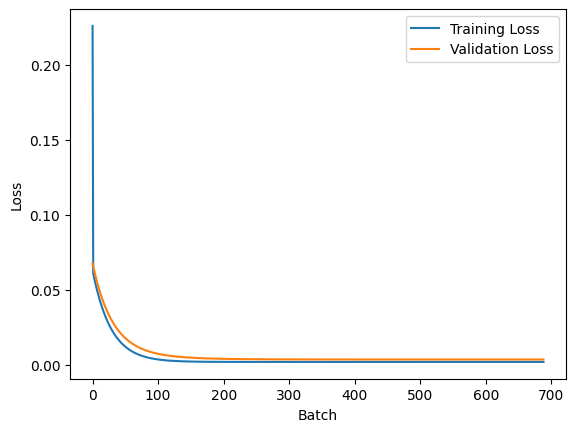

In [126]:
trainer = d2l.Trainer(max_epochs=1000)
trainer.fit(model, data_module)
plt.plot(model.train_losses, label='Training Loss')
plt.plot(model.dev_losses, label='Validation Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [127]:
model = LinearRegression(lr)
model.load_state_dict(torch.load('./saved_models/best_model.pth'))

<All keys matched successfully>

The linear equation is: y = 0.06710509210824966x + 0.7391425967216492


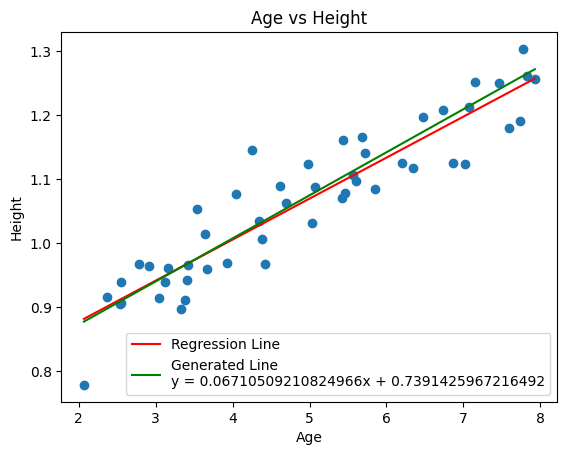

In [128]:
w, b = model.get_w_b()
print(f"The linear equation is: y = {w.item()}x + {b.item()}")

plot_csv_data(model=model)

In [129]:
test_dataloader = data_module.test_dataloader()

In [130]:
model.eval()  # set the model to evaluation mode

preds = []
truths = []

with torch.no_grad():  # we don't need gradients for evaluation
    for age, height in test_dataloader:
        # reshape data
        age = age.view(-1, 1)
        height = height.view(-1, 1)

        # forward pass
        predicted_height = model(age)

        preds.extend(predicted_height.flatten().tolist())
        truths.extend(height.flatten().tolist())


In [131]:
loss_fn = torch.nn.MSELoss()
mse = loss_fn(torch.tensor(preds), torch.tensor(truths))
mae = mean_absolute_error(truths, preds)
r2 = r2_score(truths, preds)

print(f'MSE: {mse.item()}')
print(f'MAE: {mae}')
print(f'R2 Score: {r2}')

MSE: 0.00047733564861118793
MAE: 0.01583263874053955
R2 Score: 0.9559952255400713


In [132]:
percentage_differences = []

percentage_differences = ((np.array(preds) - np.array(truths)) / np.array(truths)) * 100

for pred, gold, percentage_difference in zip(preds, truths, percentage_differences):
    print(f'Predicted value: {pred}, Gold value: {gold}, Percentage Difference: {percentage_difference:.2f}%')


Predicted value: 1.1208363771438599, Gold value: 1.1649999618530273, Percentage Difference: -3.79%
Predicted value: 1.1231179237365723, Gold value: 1.1410000324249268, Percentage Difference: -1.57%
Predicted value: 0.9095895290374756, Gold value: 0.9049999713897705, Percentage Difference: 0.51%
Predicted value: 1.0306470394134521, Gold value: 1.034000039100647, Percentage Difference: -0.32%
Predicted value: 0.9481749534606934, Gold value: 0.9390000104904175, Percentage Difference: 0.98%


# epochs = 1000
# Early stops at 689 with Patience of 5
# Learning Rate = 0.01
# The linear equation is: y = 0.06710509210824966x + 0.7391425967216492
## MSE: 0.00047733564861118793
## MAE: 0.01583263874053955
## R2 Score: 0.9559952255400713